In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray
from tqdm.notebook import tqdm
%matplotlib inline

#### Set directory

In [2]:
os.chdir("/media/silva/Disc/Research/2020-2021/Alta Floresta/")

### Gamma-ray

In [3]:
column_names = 'X Y FIDUCIAL GPSALT BARO ALTURA MDT CTB KB UB THB UUP LIVE_TIME COSMICO TEMP CTCOR KCOR UCOR THCOR CTEXP KPERC eU eTh THKRAZAO UKRAZAO UTHRAZAO LONGITUDE LATITUDE DATA HORA'.split(' ')
column_names

['X',
 'Y',
 'FIDUCIAL',
 'GPSALT',
 'BARO',
 'ALTURA',
 'MDT',
 'CTB',
 'KB',
 'UB',
 'THB',
 'UUP',
 'LIVE_TIME',
 'COSMICO',
 'TEMP',
 'CTCOR',
 'KCOR',
 'UCOR',
 'THCOR',
 'CTEXP',
 'KPERC',
 'eU',
 'eTh',
 'THKRAZAO',
 'UKRAZAO',
 'UTHRAZAO',
 'LONGITUDE',
 'LATITUDE',
 'DATA',
 'HORA']

#### Importing N-S data

In [4]:
gamma_line = pd.read_csv('1121_NORTE_MT/XYZs/1121_GamaLine.XYZ', 
                       delim_whitespace=True, names=column_names,skiprows= 11, 
                       usecols='LATITUDE LONGITUDE CTEXP KPERC eU eTh'.split(' '),
                       low_memory=False)
gamma_line.head(5) # This shows the first 5 entries 

,CTEXP,KPERC,eU,eTh,LONGITUDE,LATITUDE
0,16.467,2.595,7.122,27.322,-56.009373,-10.630615
1,15.871,3.103,7.402,22.179,-56.009369,-10.631236
2,16.090,3.657,7.389,20.263,-56.009365,-10.631860
3,17.027,4.144,7.009,22.013,-56.009361,-10.632486
4,18.178,4.432,6.365,26.112,-56.009357,-10.633114


### Dealing with dummies and nan values

In [5]:
for var in ['CTEXP', 'KPERC', 'eU', 'eTh']:
    
    var_array = gamma_line[var].values
    
    # replace dummies '*' with nan values
    var_array = np.where(var_array == '*', np.nan, var_array)

    # array float64
    var_array = np.array(var_array, dtype='float64')
    
    dummies = np.where(np.isnan(var_array) == True, 1, 0)
    
    #fillnan with mean
    var_array = np.nan_to_num(var_array, nan=np.nanmean(var_array))
    gamma_line[var] = var_array

In [6]:
gamma_line.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293465 entries, 0 to 1293464
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   CTEXP      1293465 non-null  float64
 1   KPERC      1293465 non-null  float64
 2   eU         1293465 non-null  float64
 3   eTh        1293465 non-null  float64
 4   LONGITUDE  1292627 non-null  float64
 5   LATITUDE   1292627 non-null  float64
dtypes: float64(6)
memory usage: 59.2 MB


### Outliers

In [7]:
def remove_outliers(var_array):
    # interquantile range
    Q1 = np.percentile(var_array, 25) 
    Q3 = np.percentile(var_array, 75) 
    IQR = Q3 - Q1
    
    print(f'with outliers - min:{np.min(var_array):.3f} / max:{np.max(var_array):.3f}')

    # superior limite
    RPS = np.percentile(var_array, 95) # 95th percentile
    var_array = np.where(var_array > Q3 + 1.5*IQR, RPS, var_array)
    
    # inferior limite
    RPI = np.percentile(var_array, 5) # 5th percentile
    var_array = np.where(var_array < Q1 - 1.5*IQR, RPI, var_array)
    
    print(f'without outliers - min:{np.min(var_array):.3f} / max:{np.max(var_array):.3f}')
    
    return var_array

In [8]:
for var in ['CTEXP', 'KPERC', 'eU', 'eTh']:
    print(f'----------- {var} ------------')
    gamma_line[var] = remove_outliers(gamma_line[var].values)

----------- CTEXP ------------
with outliers - min:-2.855 / max:349.734
without outliers - min:-2.855 / max:33.971
----------- KPERC ------------
with outliers - min:-1.019 / max:12.323
without outliers - min:-1.019 / max:3.268
----------- eU ------------
with outliers - min:-10.961 / max:129.590
without outliers - min:-3.021 / max:13.578
----------- eTh ------------
with outliers - min:-2.992 / max:1007.803
without outliers - min:-2.992 / max:72.107


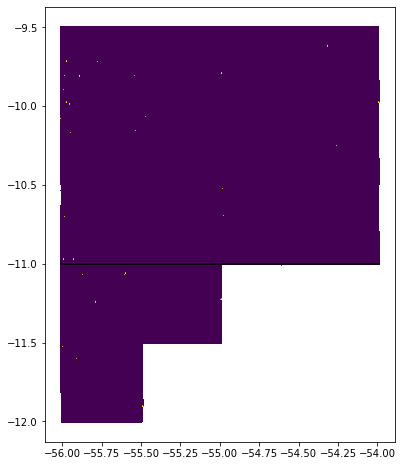

In [9]:
plt.figure(figsize=(8, 8))
plt.scatter(gamma_line.LONGITUDE, gamma_line.LATITUDE, marker='+', c=dummies, s=1)
plt.plot([gamma_line.LONGITUDE.min(), gamma_line.LONGITUDE.max()], [-11., -11.], color='k')
plt.axis('scaled')
plt.show()

#### Clip data

In [10]:
clip_1 = (gamma_line.LATITUDE >= -11.0)
clip_2 = (gamma_line.LONGITUDE >= -55.49)
clip_3 = (gamma_line.LONGITUDE <= -54.0)
clip = np.where(clip_1 & clip_2 & clip_3)

shape = gamma_line.shape
# clip data
gamma_line = gamma_line.loc[clip]
print('shapes:', shape, gamma_line.shape)

shapes: (1293465, 6) (747868, 6)


In [11]:
gamma_line.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CTEXP,747868.0,15.502194,7.374606,-2.855000,9.509750,15.207000,20.885000,33.971000
KPERC,747868.0,1.178778,1.020771,-1.019000,0.389000,0.786000,1.731000,3.268000
eU,747868.0,6.429517,2.986157,-3.021000,4.072000,6.238000,8.609000,13.578000
eTh,747868.0,32.891595,16.871614,-2.992000,19.264000,31.508000,44.579000,72.107000
LONGITUDE,747868.0,-54.751143,0.433343,-55.489992,-55.134253,-54.756930,-54.371341,-54.000001
LATITUDE,747868.0,-10.248303,0.434163,-11.000000,-10.624008,-10.248645,-9.872139,-9.495600


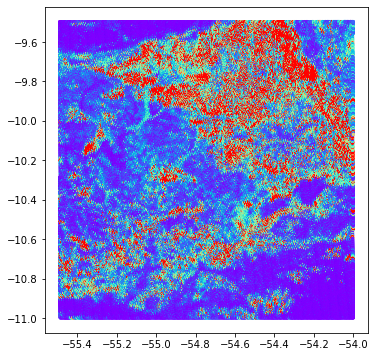

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(gamma_line.LONGITUDE, gamma_line.LATITUDE, c=gamma_line.KPERC, cmap='rainbow', s=5,
           vmin=np.percentile(gamma_line.KPERC, 10), vmax=np.percentile(gamma_line.KPERC, 90))

plt.axis('scaled')
plt.show()

#### Importing E-W data

In [13]:
gamma_tie = pd.read_csv('1121_NORTE_MT/XYZs/1121_GamaTie.XYZ', 
                       delim_whitespace=True, names=column_names,skiprows=11, 
                       usecols='LATITUDE LONGITUDE CTEXP KPERC eU eTh'.split(' '),
                       low_memory=False)
gamma_tie.head(5) # This shows the first 5 entries 

,CTEXP,KPERC,eU,eTh,LONGITUDE,LATITUDE
0,5.233,0.095,3.156,10.020,-56.006789,-11.971230
1,5.315,0.097,3.242,10.189,-56.006176,-11.971217
2,5.397,0.100,3.325,10.364,-56.005565,-11.971199
3,5.477,0.103,3.404,10.541,-56.004956,-11.971179
4,5.538,0.114,3.440,10.708,-56.004348,-11.971157


#### Dealing with dummies and nan values

In [14]:
for var in ['CTEXP', 'KPERC', 'eU', 'eTh']:
    
    var_array = gamma_tie[var].values
    
    # replace dummies '*' with nan values
    var_array = np.where(var_array == '*', np.nan, var_array)

    # array float64
    var_array = np.array(var_array, dtype='float64')
    
    dummies = np.where(np.isnan(var_array) == True, 1, 0)
    
    #fillnan with mean
    var_array = np.nan_to_num(var_array, nan=np.nanmean(var_array))
    gamma_tie[var] = var_array

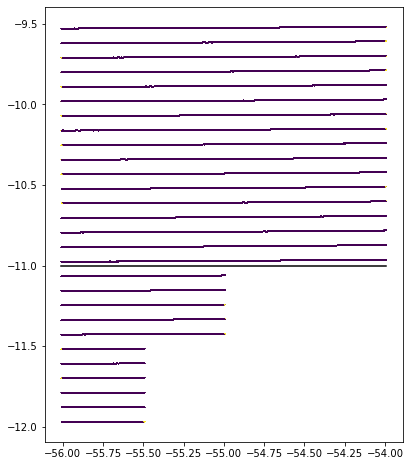

In [15]:
plt.figure(figsize=(8, 8))
plt.scatter(gamma_tie.LONGITUDE, gamma_tie.LATITUDE, marker='+', c=dummies, s=1)
plt.plot([gamma_tie.LONGITUDE.min(), gamma_tie.LONGITUDE.max()], [-11., -11.], color='k')
plt.axis('scaled')
plt.show()

In [16]:
for var in ['CTEXP', 'KPERC', 'eU', 'eTh']:
    print(f'----------- {var} ------------')
    gamma_tie[var] = remove_outliers(gamma_tie[var].values)

----------- CTEXP ------------
with outliers - min:0.381 / max:94.993
without outliers - min:0.381 / max:34.421
----------- KPERC ------------
with outliers - min:-0.179 / max:7.981
without outliers - min:-0.179 / max:3.234
----------- eU ------------
with outliers - min:-1.481 / max:45.806
without outliers - min:-1.481 / max:13.564
----------- eTh ------------
with outliers - min:-0.492 / max:238.676
without outliers - min:-0.492 / max:72.074


#### Clip data

In [17]:
clip_1 = (gamma_tie.LATITUDE >= -11.0)
clip_2 = (gamma_tie.LONGITUDE >= -55.49)
clip_3 = (gamma_tie.LONGITUDE <= -54.0)
clip = np.where(clip_1 & clip_2 & clip_3)

shape = gamma_tie.shape
# clip data
gamma_tie = gamma_tie.loc[clip]
print('shapes:', shape, gamma_tie.shape)

shapes: (68489, 6) (40907, 6)


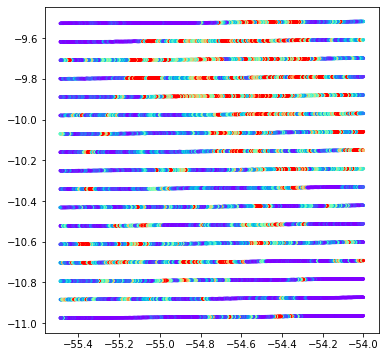

In [18]:
plt.figure(figsize=(6, 6))
plt.scatter(gamma_tie.LONGITUDE, gamma_tie.LATITUDE, c=gamma_tie.KPERC, cmap='rainbow', s=5,
           vmin=np.percentile(gamma_tie.KPERC, 10), vmax=np.percentile(gamma_tie.KPERC, 90))

plt.axis('scaled')
plt.show()

#### Merge datasets

In [19]:
gamma_data = pd.concat([gamma_line, gamma_tie], axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=False)
print(gamma_data.shape)
gamma_data.head(3)

(788775, 6)


,CTEXP,KPERC,eU,eTh,LONGITUDE,LATITUDE
0,5.962,0.356,2.685,13.139,-55.489992,-10.287277
1,5.401,0.359,2.382,11.795,-55.489983,-10.287938
2,4.811,0.349,2.351,9.802,-55.489976,-10.288599


In [20]:
from shapely import geometry
# EPSG:4674
crs = "+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"

# create geodataframe
gamma_data['geometry'] = gpd.points_from_xy(gamma_data.LONGITUDE, gamma_data.LATITUDE)
gamma_data = gpd.GeoDataFrame(gamma_data, geometry='geometry', crs=crs)
gamma_data.head()

,CTEXP,KPERC,eU,eTh,LONGITUDE,LATITUDE,geometry
0,5.962,0.356,2.685,13.139,-55.489992,-10.287277,POINT (-55.48999 -10.28728)
1,5.401,0.359,2.382,11.795,-55.489983,-10.287938,POINT (-55.48998 -10.28794)
2,4.811,0.349,2.351,9.802,-55.489976,-10.288599,POINT (-55.48998 -10.28860)
3,4.663,0.306,2.293,9.599,-55.489970,-10.289259,POINT (-55.48997 -10.28926)
4,5.161,0.223,2.107,12.154,-55.489965,-10.289917,POINT (-55.48996 -10.28992)


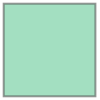

In [21]:
multipoints = geometry.MultiPoint(gamma_data['geometry'])
bounds = multipoints.envelope
bounds

In [22]:
# export bounds
gpd.GeoSeries(bounds).to_file('VETORES/bounds.gpkg', 'GPKG')

### Interpolation

In [23]:
def nynx(cellsize, coords):
    
    cellsize = cellsize/111.139e3 #[meters to degrees]
    xmin, ymin = coords[0], coords[1]
    xmax, ymax = coords[2], coords[3]
    nx = int(np.around((xmax-xmin)/cellsize, 2))
    ny = int(np.around((ymax-ymin)/cellsize, 2))
    
    return cellsize, ny, nx, xmin, ymin, xmax, ymax

In [24]:
# bounds coordinates
coords = gpd.GeoSeries(bounds).geometry.bounds
print(coords)

        minx  miny       maxx    maxy
0 -55.489992 -11.0 -54.000001 -9.4956


In [25]:
cellsize = 125 #[meters]
cellsize, ny, nx, xmin, ymin, xmax, ymax = nynx(cellsize, coords.iloc[0, :].values)
print(cellsize, ny, nx)

0.0011247176958583396 1337 1324


In [26]:
# create a grid
yi = np.linspace(ymin+cellsize, ymax-cellsize, ny-2)
xi = np.linspace(xmin+cellsize, xmax-cellsize, nx-2)
ny = ny-2
nx = nx-2

x, y = np.meshgrid(xi, yi)
print(x.shape, y.shape)

(1335, 1322) (1335, 1322)


In [27]:
import fatiando

gamma_vars = {}
for var in tqdm(['CTEXP', 'KPERC', 'eU', 'eTh']):
    img =\
    fatiando.interp_at(gamma_data.LONGITUDE.values, gamma_data.LATITUDE.values, 
    gamma_data[var].values, x.ravel(), y.ravel(), algorithm='linear', extrapolate=True).reshape(ny, nx)
    # median filter
    gamma_vars[var] = img 

  0%|          | 0/4 [00:00<?, ?it/s]

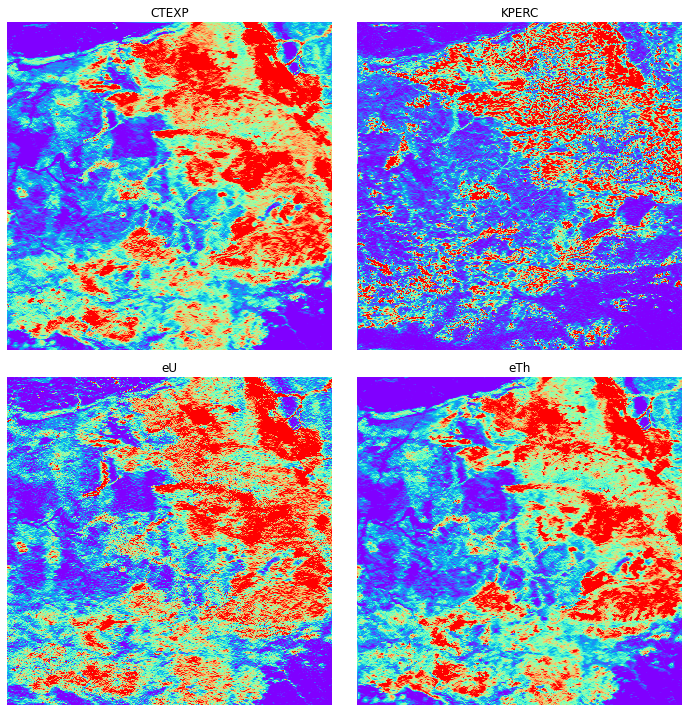

In [49]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
ax = ax.flatten()

for i, var in enumerate(['CTEXP', 'KPERC', 'eU', 'eTh']):
    ax[i].pcolormesh(x, y, gamma_vars[var], shading='auto',
               vmin=np.percentile(gamma_vars[var], 10),
                 vmax=np.percentile(gamma_vars[var], 90), cmap='rainbow')
    
    ax[i].set_aspect(1)
    ax[i].axis('off')
    ax[i].set_title(var)
    
plt.tight_layout()
plt.show()

In [126]:
# gamma variables
vars_dict = {}
vars_dict['TC'] = (['y', 'x'], gamma_vars['CTEXP'], {'variable': 'Total Count', 'unit': 'nGy/h'})
vars_dict['Kperc'] = (['y', 'x'], gamma_vars['KPERC'], {'variable': 'Potassium Concentration', 'unit': '%'})
vars_dict['eTh'] = (['y', 'x'], gamma_vars['eU'], {'variable': 'Equivalent Thorium', 'unit': 'ppm'})
vars_dict['eU'] = (['y', 'x'], gamma_vars['eTh'], {'variable': 'Equivalent Uranium', 'unit': 'ppm'})

# coordinates
coords = {}
coords['lon'] = (["y", "x"], x, {'crs': crs, 'EPSG':'4674'})
coords['lat'] = (["y", "x"], y, {'crs': crs, 'EPSG':'4674'})

attrs = dict(description="Geoscientific data from Alta Floresta, MT, Brazil.")

In [127]:
dset = xarray.Dataset(vars_dict, coords, attrs)
dset

<xarray.Dataset>
Dimensions:  (y: 1335, x: 1322)
Coordinates:
    lon      (y, x) float64 -55.49 -55.49 -55.49 -55.49 ... -54.0 -54.0 -54.0
    lat      (y, x) float64 -11.0 -11.0 -11.0 -11.0 ... -9.497 -9.497 -9.497
Dimensions without coordinates: y, x
Data variables:
    TC       (y, x) float64 3.963 3.963 3.963 2.884 ... 10.11 10.15 10.2 10.25
    Kperc    (y, x) float64 0.3964 0.3964 0.3964 0.3935 ... 0.6163 0.5725 0.5287
    eTh      (y, x) float64 2.669 2.669 2.669 1.691 ... 4.492 4.843 5.193 5.544
    eU       (y, x) float64 6.307 6.307 6.307 4.736 ... 20.72 20.39 20.07 19.75
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

In [131]:
def export_tif(ds, crs, path):

    import rasterio
    import rioxarray
    ds.rio.set_crs(crs, inplace=True)
    ds.rio.to_raster(path, driver='GTiff')
    
    x = ds['lon'].data
    y = ds['lat'].data
    src = rasterio.open(path)
    # get meta dict
    meta = src.meta

    # calculate pixel size
    pixel_size = np.diff(x).min()

    # add new affine
    meta['transform'] = rasterio.Affine(float(pixel_size), float(0.0), x.min(),
                    0.0, float(-pixel_size), float(y.max()))

    # export to tiff
    with rasterio.open(path, 'w', **meta) as raster:
        # If array is in  (y, x, z) order (cols, rows, bands)
        source = np.flip(src.read(), axis=1)
        raster.write(source)

In [132]:
# save dataset to netcdf
dset.to_netcdf(path='DATASETS/dset_AF.nc', mode='w', format='NETCDF4')

In [133]:
export_tif(dset, "epsg:4674", 'RASTERS/gamma.tiff')

### Magnetic data

In [144]:
column_names = 'X Y FIDUCIAL GPSALT BARO ALTURA MDT MAGBASE MAGBRU MAGCOM MAGCOR MAGNIV MAGMIC MAGIGRF IGRF LONGITUDE LATITUDE DATA HORA'.split(' ')
column_names

['X',
 'Y',
 'FIDUCIAL',
 'GPSALT',
 'BARO',
 'ALTURA',
 'MDT',
 'MAGBASE',
 'MAGBRU',
 'MAGCOM',
 'MAGCOR',
 'MAGNIV',
 'MAGMIC',
 'MAGIGRF',
 'IGRF',
 'LONGITUDE',
 'LATITUDE',
 'DATA',
 'HORA']

### Importing N-S data

In [149]:
mag_line = pd.read_csv('1121_NORTE_MT/XYZs/1121_MAGLINE.XYZ', 
                       delim_whitespace=True, names=column_names,skiprows=11, 
                       usecols=['LATITUDE', 'LONGITUDE', 'MAGIGRF'],
                       low_memory=False)
mag_line.head() 

,MAGIGRF,LONGITUDE,LATITUDE
0,36.347,-56.009375,-10.630428
1,39.179,-56.009373,-10.630490
2,41.939,-56.009373,-10.630552
3,44.615,-56.009373,-10.630613
4,47.205,-56.009373,-10.630677


In [159]:
var_array = mag_line['MAGIGRF']
    
if np.where(var_array == '*')[0].size > 0:
    # replace dummies '*' with nan values
    var_array = np.where(var_array == '*', np.nan, var_array)

# array float64
var_array = np.array(var_array, dtype='float64')
    
dummies = np.where(np.isnan(var_array) == True, 1, 0)
    
#fillnan with mean
var_array = np.nan_to_num(var_array, nan=np.nanmean(var_array))
mag_line['MAGIGRF'] = var_array

### Outliers

In [160]:
mag_line['MAGIGRF'] = remove_outliers(mag_line.MAGIGRF.values)

with outliers - min:-2355.230 / max:1291.055
without outliers - min:-232.793 / max:146.367


### Clip data

In [161]:
clip_1 = (mag_line.LATITUDE >= -11.0)
clip_2 = (mag_line.LONGITUDE >= -55.49)
clip_3 = (mag_line.LONGITUDE <= -54.0)
clip = np.where(clip_1 & clip_2 & clip_3)

shape = mag_line.shape
# clip data
mag_line = mag_line.loc[clip]
print('shapes:', shape, mag_line.shape)

shapes: (12926387, 3) (7478375, 3)


### Importing E-W data

In [164]:
mag_tie = pd.read_csv('1121_NORTE_MT/XYZs/1121_MAGTIE.XYZ', 
                       delim_whitespace=True, names=column_names,skiprows=11, 
                       usecols=['LATITUDE', 'LONGITUDE', 'MAGIGRF'])
mag_tie.head()

,MAGIGRF,LONGITUDE,LATITUDE
0,83.558,-56.007095,-11.971235
1,83.568,-56.007033,-11.971233
2,83.577,-56.006973,-11.971233
3,83.588,-56.006912,-11.971233
4,83.596,-56.006850,-11.971232


In [165]:
var_array = mag_tie['MAGIGRF']
    
if np.where(var_array == '*')[0].size > 0:
    # replace dummies '*' with nan values
    var_array = np.where(var_array == '*', np.nan, var_array)

# array float64
var_array = np.array(var_array, dtype='float64')
    
dummies = np.where(np.isnan(var_array) == True, 1, 0)
    
#fillnan with mean
var_array = np.nan_to_num(var_array, nan=np.nanmean(var_array))
mag_tie['MAGIGRF'] = var_array

### Outliers

In [166]:
mag_tie['MAGIGRF'] = remove_outliers(mag_tie.MAGIGRF.values)

with outliers - min:-1012.085 / max:765.632
without outliers - min:-229.097 / max:141.902


### Clip data

In [167]:
clip_1 = (mag_tie.LATITUDE >= -11.0)
clip_2 = (mag_tie.LONGITUDE >= -55.49)
clip_3 = (mag_tie.LONGITUDE <= -54.0)
clip = np.where(clip_1 & clip_2 & clip_3)

shape = mag_tie.shape
# clip data
mag_tie = mag_tie.loc[clip]
print('shapes:', shape, mag_tie.shape)

shapes: (684307, 3) (409044, 3)


### Merge datasets

In [168]:
mag_data = pd.concat([mag_line, mag_tie], axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=False)
print(mag_data.shape)
mag_data.head(3)

(7887419, 3)


,MAGIGRF,LONGITUDE,LATITUDE
0,32.803,-55.490000,-10.286682
1,31.948,-55.490000,-10.286747
2,31.135,-55.489998,-10.286813


### Interpolation

In [171]:
from scipy import ndimage
resmag = fatiando.interp_at(mag_data.LONGITUDE.values, mag_data.LATITUDE.values, 
    mag_data['MAGIGRF'].values, x.ravel(), y.ravel(), algorithm='linear', extrapolate=True).reshape(ny, nx)

resmag = ndimage.median_filter(resmag, size=3)
# compute analytic signal amplitude
asa = fatiando.ansig(x.ravel(), y.ravel(), resmag.ravel(), shape=(ny, nx)).reshape((ny, nx))

# compute tilt derivative
tilt = fatiando.tilt(x.ravel(), y.ravel(), resmag.ravel(), shape=(ny, nx)).reshape((ny, nx))

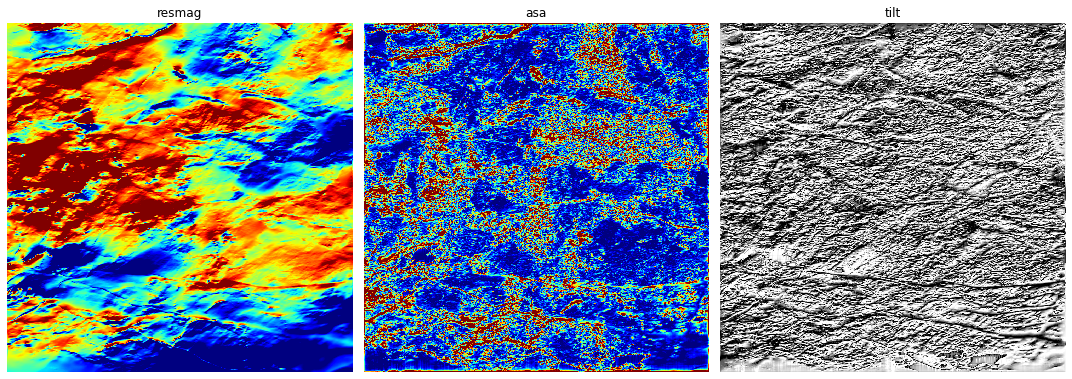

In [178]:
mag_vars = {'resmag':resmag, 'asa':asa, 'tilt':tilt}

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 8))
ax = ax.flatten()

cmaps = 'jet jet Greys'.split(' ')

for i, var in enumerate(['resmag', 'asa', 'tilt']):
    ax[i].pcolormesh(x, y, mag_vars[var], shading='auto',
               vmin=np.percentile(mag_vars[var], 10),
                 vmax=np.percentile(mag_vars[var], 90), cmap=cmaps[i])
    
    ax[i].set_aspect(1)
    ax[i].axis('off')
    ax[i].set_title(var)
    
plt.tight_layout()
plt.show()

In [174]:
# add to dataset
dset['resmag'] = (['y', 'x'], resmag, {'variable': 'Residual Magnetism', 'unit': 'nT (nano Tesla)'})
dset['asa'] = (['y', 'x'], asa, {'variable': 'Analytic Signal Amplitude (ASA)', 'unit': 'nT (nano Tesla)'})
dset['tilt'] = (['y', 'x'], tilt, {'variable': 'Tilt Derivative', 'unit': 'rad'})
dset

<xarray.Dataset>
Dimensions:  (y: 1335, x: 1322)
Coordinates:
    lon      (y, x) float64 -55.49 -55.49 -55.49 -55.49 ... -54.0 -54.0 -54.0
    lat      (y, x) float64 -11.0 -11.0 -11.0 -11.0 ... -9.497 -9.497 -9.497
Dimensions without coordinates: y, x
Data variables:
    TC       (y, x) float64 3.963 3.963 3.963 2.884 ... 10.11 10.15 10.2 10.25
    Kperc    (y, x) float64 0.3964 0.3964 0.3964 0.3935 ... 0.6163 0.5725 0.5287
    eTh      (y, x) float64 2.669 2.669 2.669 1.691 ... 4.492 4.843 5.193 5.544
    eU       (y, x) float64 6.307 6.307 6.307 4.736 ... 20.72 20.39 20.07 19.75
    resmag   (y, x) float64 -96.52 -96.52 -96.28 -96.14 ... -39.66 -35.35 -31.03
    asa      (y, x) float64 5.716e+04 4.404e+04 ... 1.345e+05 1.416e+05
    tilt     (y, x) float64 0.1791 -0.6696 -0.7063 ... 0.8815 0.8708 0.9039
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

In [175]:
# save dataset to netcdf
dset.to_netcdf(path='DATASETS/dset_AF.nc', mode='w', format='NETCDF4')

In [177]:
export_tif(dset, "epsg:4674", 'RASTERS/geoph.tiff')

### Digital Terrain Model

In [180]:
import fiona
with fiona.open("VETORES/bounds.gpkg", "r") as geopack:
    shapes = [feature["geometry"] for feature in geopack]

In [181]:
srtm = {}
with rasterio.open('RASTERS/SRTM.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, [shapes[0]], crop=True)
    out_meta = src.meta
    ny_, nx_ = out_image.shape[1], out_image.shape[2]
    out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        
        
# coordenates 
x0 = np.linspace(shapes[0]['coordinates'][0][0][0], shapes[0]['coordinates'][0][2][0], nx_)
y0 = np.linspace(shapes[0]['coordinates'][0][0][1], shapes[0]['coordinates'][0][2][1], ny_)

if x0[0] == out_transform[2]:
        pass
else:
    x0 = x0[::-1]

if y0[0] == out_transform[5]:
             pass
else:
    y0 = y0[::-1]
        
x0, y0 = np.meshgrid(x0, y0)
        
# adding to dict
srtm['x'] = np.flip(x0, axis=1)
srtm['y'] = np.flip(y0, axis=1)
srtm['dtm'] = np.where(out_image.ravel() < 0, 0., out_image.ravel()).reshape((ny_, nx_))
srtm['extent'] = [shapes[0]['coordinates'][0][0][0], shapes[0]['coordinates'][0][2][0], 
                    shapes[0]['coordinates'][0][0][1], shapes[0]['coordinates'][0][2][1]]
srtm['meta'] = out_meta

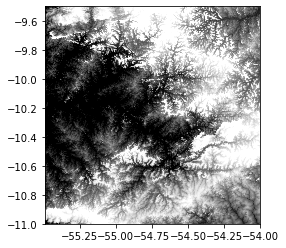

In [182]:
fig, ax = plt.subplots()
ax.pcolormesh(srtm['x'], srtm['y'], srtm['dtm'], shading='auto',
               cmap='Greys_r', vmin=np.percentile(srtm['dtm'], 10), vmax=np.percentile(srtm['dtm'], 90))
ax.set_aspect(1)
plt.show()

In [183]:
# interp dtm 
from scipy.interpolate import griddata
dtm = griddata((srtm['x'].ravel(), srtm['y'].ravel()), srtm['dtm'].ravel(), 
                                      (x, y), method='nearest').reshape((ny, nx))

In [186]:
dset['DTM'] = (['y', 'x'], np.array(dtm, dtype='float64'), {'variable':'Digital Terrain Model', 'unit': 'meters'})
dset

<xarray.Dataset>
Dimensions:  (y: 1335, x: 1322)
Coordinates:
    lon      (y, x) float64 -55.49 -55.49 -55.49 -55.49 ... -54.0 -54.0 -54.0
    lat      (y, x) float64 -11.0 -11.0 -11.0 -11.0 ... -9.497 -9.497 -9.497
Dimensions without coordinates: y, x
Data variables:
    TC       (y, x) float64 3.963 3.963 3.963 2.884 ... 10.11 10.15 10.2 10.25
    Kperc    (y, x) float64 0.3964 0.3964 0.3964 0.3935 ... 0.6163 0.5725 0.5287
    eTh      (y, x) float64 2.669 2.669 2.669 1.691 ... 4.492 4.843 5.193 5.544
    eU       (y, x) float64 6.307 6.307 6.307 4.736 ... 20.72 20.39 20.07 19.75
    resmag   (y, x) float64 -96.52 -96.52 -96.28 -96.14 ... -39.66 -35.35 -31.03
    asa      (y, x) float64 5.716e+04 4.404e+04 ... 1.345e+05 1.416e+05
    tilt     (y, x) float64 0.1791 -0.6696 -0.7063 ... 0.8815 0.8708 0.9039
    DTM      (y, x) float64 273.0 275.0 272.0 266.0 ... 315.0 307.0 305.0 300.0
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

In [190]:
# save dataset to netcdf
dset.to_netcdf(path='DATASETS/dset_AF.nc', mode='w', format='NETCDF4')

In [189]:
export_tif(dset, "epsg:4674", 'RASTERS/geoscientic_data.tiff')